# Using Yelp Data to Recommend the Location of the Next Lou Malnati: Preprocessing, Training, and Modeling 
Chicago pizza magnate Lou Malnati is looking to expand his national pizza empire. With 59 locations in Illinois, seven in Arizona, four in Wisconsin, and four in Indiana. Malnati is interested in potentially expanding both within Arizona and Indiana and to other states. In particular, Malnati is interested in Florida, Pennsylvania, New Jersey, and Missouri. 
Malnati’s restaurants are known for their deep dish pizza, and are looking for locations that either might not have deep dish options or locations where the pizza options are not satisfying consumers. Malnati's team believes that they can both introduce deep dish to new customers and lure currently unsatisfied customers with their nationally recognized pizza brand. 
Malnati’s team has requested an analysis of the existing landscape in the four new states along with Arizona and Indiana. They want to understand which state holds the most promise for more or more new locations. Ideally, they would like to open up multiple locations and want to know whether one of the new states would be a better option than continuing to open up restaurants in Arizona and Indiana.

**The purpose of this notebook is to pre-process the data, to split the data into training and test sets, and to build and evaluate several models for predicting the star rating based on the comment.**

## Data Sources
All data has been downloaded directly from [Yelp](https://www.yelp.com/dataset):

1. yelp_academic_dataset_business.json: contains business data including location data, attributes, and categories
2. yelp_academic_dataset_review.json: contains full review text data including the user_id that wrote the review and the business_id the review is written for.

The data was loaded and read into pandas dataframes in the 1-ridgway-read-data notebook. The dataframes were filtered for only businesses with "pizza" in the categories and then pickled. The pickled datasets were then cleaned, merged, the text feature was prepared (e.g., tokenization, lemminization), and pickled once again:

- processed.pkl: pickled dataframe containing reviews and select business information for pizza businesses in select states

## Changes
- 03-21-22: Started pre-processing
- 03-28-22: Models, comparison, and hyper parameter tuning
- 03-29-22: Finalized notebook

## Summary of Pre-Processing and Modeling

1. **Load Dataset:** The dataset from the EDA notebook was loaded.
2. **Sentiment Analysis:** Vader sentiment analysis was conducted to identify the top positive and negative comments. The dataset skewed toward positive comments with 95% of the comments being classified as positive. This was an interesting result given that only 74% of the scores were positive (i.e., given 4-5 stars).
3. **Split for Training:** The dataset was split using an 80/20 split for training/testing.
4. **Modeling:** Three models were developed, including Naive Bayes, logistic regression, and a random forest classifer.
5. **Model Comparison:** The logistic regression model out-performed the other two models on all metrics, including accuracy, F1, and lift.
6. **Hyper Parameter Tuning:** The logistic regression model was tuned using GridSearchCV resulting in ~2% increase in accuracy.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
#nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve, roc_auc_score
from mlxtend.evaluate import lift_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## File Locations

In [2]:
processed_df = '../data/processed/processed.pkl'

## Load Data

In [3]:
df = pd.read_pickle(processed_df)

In [4]:
# Scale back to only include the cleaned, lemmatized text in a string format and the binary rating
df = df[['text_for_cloud_lemmatized', 'binary_rating']]
df.columns = ['text', 'pos_rating']

In [5]:
df.head()

,text,pos_rating
2527,nice italian restauranthowever previous visit ...,0.0
3471,today ethiopian food fiasco see selam review l...,1.0
3473,delicious wish take reservation friend fiance ...,1.0
3480,im sure havent write review pi time time take ...,1.0
3482,deep dish pizza fantastic like reviewer mentio...,1.0


## Sentiment Analysis
Adapted from https://github.com/nhcamp/Yelp-Burrito-Reviews/blob/master/Capstone%202.ipynb and https://github.com/jonathanoheix/Sentiment-analysis-with-hotel-reviews/blob/master/Sentiment%20analysis%20with%20hotel%20reviews.ipynb

In [6]:
# Define a function to caluclate the polarity scores using Vader sentiment analysis
def apply_sentiment_intensity_analysis(sentence):
    """Applies the polarity scores function to a sentence. Used with df.apply(), returns dictionary. 
    """
    analyzer = SentimentIntensityAnalyzer()
    polarity_dict = analyzer.polarity_scores(sentence)
    return polarity_dict

df['polarity_score'] = df['text'].apply(lambda x: apply_sentiment_intensity_analysis(x))

In [7]:
# Split out the various scores
df = pd.concat([df.drop(['polarity_score'], axis=1), df['polarity_score'].apply(pd.Series)], axis=1)

In [8]:
df.head()

,text,pos_rating,neg,neu,pos,compound
2527,nice italian restauranthowever previous visit ...,0.0,0.103,0.675,0.221,0.9840
3471,today ethiopian food fiasco see selam review l...,1.0,0.046,0.779,0.175,0.8519
3473,delicious wish take reservation friend fiance ...,1.0,0.056,0.507,0.437,0.9937
3480,im sure havent write review pi time time take ...,1.0,0.078,0.605,0.318,0.9657
3482,deep dish pizza fantastic like reviewer mentio...,1.0,0.023,0.718,0.260,0.9806


In [9]:
# Determine how many of the reviews have a positive rating (i.e., 1.0 = 4+ stars)
df['pos_rating'].value_counts(normalize=True)

1.0    0.736718
0.0    0.263282
Name: pos_rating, dtype: float64

In [10]:
# Determine how many of the reviews have a positive sentiment
(df[df['compound']>0.05].count())/df.shape[0]

text          0.940231
pos_rating    0.940231
neg           0.940231
neu           0.940231
pos           0.940231
compound      0.940231
dtype: float64

<div class="alert alert-block alert-info">
    About 94% of the reviews are considered to be positive. However, only 74% of the reviews were a 4 or 5. 
</div>

### Top Positive and Top Negative Comments

In [11]:
# Add number of characters column
df['nb_chars'] = df['text'].apply(lambda x: len(x))

# Add number of words column
df['nb_words'] = df['text'].apply(lambda x: len(x.split(" ")))

In [12]:
# Determine the Hhghest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["text", "pos"]].head(10)

,text,pos
249927,awesome deep dish great friendly efficient ser...,0.802
164904,love place deep dish pizza good salad pretty g...,0.767
209528,love place great food great service love deep ...,0.751
65476,fantastic pizza great service staff friendly i...,0.750
3579,amaze happy hour special great food great serv...,0.746
34302,best best dare find good deepdish pizza,0.739
78732,tuesday special always great good food great v...,0.739
70517,love deep dish pizza amazing,0.727
327141,staff super helpful sweet server joe amaze sup...,0.720
188462,awesome chicagostyle deep dish cheesy saucy li...,0.719


In [13]:
# Determine the lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["text", "neg"]].head(10)

,text,neg
281738,deep dish die mouth water think wait worth,0.331
188291,happy experience server ownermanager whatever ...,0.321
189211,hard mess deep dish pizza love bread fan year ...,0.315
135110,sure hype call deep dish pizza insult chicago ...,0.312
326264,really hate people think good deep dish pizza,0.310
206802,get flat pizza get pan pizza 100x good flat ac...,0.309
330298,go beer food time deep dish style pizza ok som...,0.308
99655,dont know blue haired girl incompetent make di...,0.301
188354,sad food good service horrendous weve come yea...,0.298
202094,one place deliver house give shoot really good...,0.298


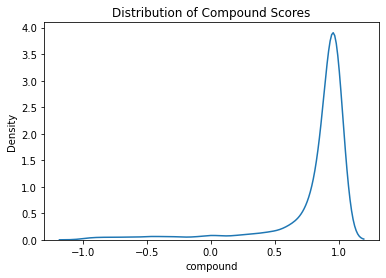

In [14]:
# Plot sentiment distribution for reviews
_ = sns.kdeplot(data=df, x='compound').set(title='Distribution of Compound Scores')
plt.show()

## Split into Testing and Training Datasets

In [15]:
# Split the dataset for training and testing
X = df['text']
y = df['pos_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Confirm size of X_train and X_test
X_train.shape, X_test.shape

((3734,), (934,))

## Modeling

### Naive Bayes Classifer for Multinomial Models

In [17]:
# Use Pipeline to fit the model
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [18]:
# Determine the accuracy of the model
y_pred_nb = nb.predict(X_test)
accuracy_nb=nb.score(X_test,y_test)
f1_nb = f1_score(y_test, y_pred_nb)
lift_nb = lift_score(y_test, y_pred_nb)

print('Accuracy of Naive Bayes:', accuracy_nb)
print('F1-Score of Naive Bayes:', f1_nb)
print('Lift Score of Naive Bayes:', lift_nb)
print(' ')
print(' ')
print(classification_report(y_test, y_pred_nb))

Accuracy of Naive Bayes: 0.7291220556745182
F1-Score of Naive Bayes: 0.8429546865301055
Lift Score of Naive Bayes: 1.002145922746781
 
 
              precision    recall  f1-score   support

         0.0       1.00      0.01      0.02       255
         1.0       0.73      1.00      0.84       679

    accuracy                           0.73       934
   macro avg       0.86      0.50      0.43       934
weighted avg       0.80      0.73      0.62       934



In [19]:
# Cross validation
cv_scores_nb_test = cross_val_score(nb,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_nb_train = cross_val_score(nb,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_nb_test)
cv_scores_nb_test = cv_scores_nb_test.mean()
cv_scores_nb_train = cv_scores_nb_train.mean()
cv_scores_std_test_nb = cv_scores_nb_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_nb))

[0.81646482 0.79065744 0.80132641 0.78474625 0.79099492]
Mean cross validation test score: 0.7968379683027896
Mean cross validation train score: 0.8196616441977268
Standard deviation in cv test scores: 0.0


### Logistic Regression

In [20]:
# Use Pipeline to fit the model
lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(max_iter=1000)),
              ])
lr.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=1000))])

In [21]:
# Determine the accuracy of the model
y_pred_lr = lr.predict(X_test)
accuracy_lr = lr.score(X_test,y_test)
f1_lr = f1_score(y_test, y_pred_lr)
lift_lr = lift_score(y_test, y_pred_lr)

print('Accuracy of Logistic Regression:', accuracy_lr)
print('F1-Score of Logistic Regression:', f1_lr)
print('Lift Score of Logistic Regression:', lift_lr)
print(' ')
print(' ')
print(classification_report(y_test, y_pred_lr))

Accuracy of Logistic Regression: 0.8511777301927195
F1-Score of Logistic Regression: 0.9053778080326752
Lift Score of Logistic Regression: 1.15790160511549
 
 
              precision    recall  f1-score   support

         0.0       0.90      0.51      0.65       255
         1.0       0.84      0.98      0.91       679

    accuracy                           0.85       934
   macro avg       0.87      0.74      0.78       934
weighted avg       0.86      0.85      0.84       934



In [22]:
# Cross validation
cv_scores_lr_test = cross_val_score(lr,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_lr_train = cross_val_score(lr,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_lr_test)
cv_scores_lr_test = cv_scores_lr_test.mean()
cv_scores_lr_train = cv_scores_lr_train.mean()
cv_scores_std_test_lr = cv_scores_lr_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.90643022 0.91147636 0.82439446 0.86894464 0.83064633]
Mean cross validation test score: 0.8683784014695203
Mean cross validation train score: 0.890317716174955
Standard deviation in cv test scores: 0.0


### Random Forest Classifer

In [23]:
# Use Pipeline to fit the model
rf = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(n_estimators = 100, random_state = 42)),
              ])
rf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(random_state=42))])

In [24]:
# Determine the accuracy of the model
y_pred_rf = rf.predict(X_test)
accuracy_rf = rf.score(X_test,y_test)
f1_rf = f1_score(y_test, y_pred_rf)
lift_rf = lift_score(y_test, y_pred_rf)

print('Accuracy of Random Forest Classifer:', accuracy_rf)
print('F1-Score of Random Forest Classifer:', f1_rf)
print('Lift Score of Random Forest Classifer:', lift_rf)
print(' ')
print(' ')
print(classification_report(y_test, y_pred_rf))

Accuracy of Random Forest Classifer: 0.7762312633832976
F1-Score of Random Forest Classifer: 0.8655948553054663
Lift Score of Random Forest Classifer: 1.056788454684232
 
 
              precision    recall  f1-score   support

         0.0       0.90      0.20      0.33       255
         1.0       0.77      0.99      0.87       679

    accuracy                           0.78       934
   macro avg       0.83      0.60      0.60       934
weighted avg       0.80      0.78      0.72       934



In [25]:
# Cross validation
cv_scores_rf_test = cross_val_score(rf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_rf_train = cross_val_score(rf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_rf_test)
cv_scores_rf_test = cv_scores_rf_test.mean()
cv_scores_rf_train = cv_scores_rf_train.mean()
cv_scores_std_test_rf = cv_scores_rf_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_rf))

[0.85200404 0.85899654 0.78078143 0.79901961 0.78612927]
Mean cross validation test score: 0.8153861762569952
Mean cross validation train score: 0.8598206411597268
Standard deviation in cv test scores: 0.0


## Model Comparison

In [26]:
#Compare model by score and accuracy
myLabels = ['Naive Bayes', 'Logistic Regression','Random Forest']
score_test= [cv_scores_nb_test, cv_scores_lr_test, cv_scores_rf_test]
score_train= [cv_scores_nb_train, cv_scores_lr_train, cv_scores_rf_train]
accuracy_score = [accuracy_nb, accuracy_lr, accuracy_rf]
f1_score = [f1_nb, f1_lr, f1_rf]
lift_score = [lift_nb, lift_lr, lift_rf]

score_tab_acc = pd.DataFrame(list(zip(myLabels, accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab_f1 = pd.DataFrame(list(zip(myLabels, f1_score)), 
               columns =['Algorithm', 'Model F1 score']) 

score_tab_lift = pd.DataFrame(list(zip(myLabels, lift_score)), 
               columns =['Algorithm', 'Model Lift score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 


combined_score_tabs = score_tab_acc.merge(score_tab_f1,on='Algorithm').merge(score_tab_lift,on='Algorithm').merge(score_tab,on='Algorithm')
combined_score_tabs

,Algorithm,Model accuracy score,Model F1 score,Model Lift score,ROC-AUC train score,ROC-AUC test score
0,Naive Bayes,0.729122,0.842955,1.002146,0.819662,0.796838
1,Logistic Regression,0.851178,0.905378,1.157902,0.890318,0.868378
2,Random Forest,0.776231,0.865595,1.056788,0.859821,0.815386


<div class="alert alert-block alert-info">
    <b>Logistic Regression is the highest perfomring model across all metrics.</b>
</div>

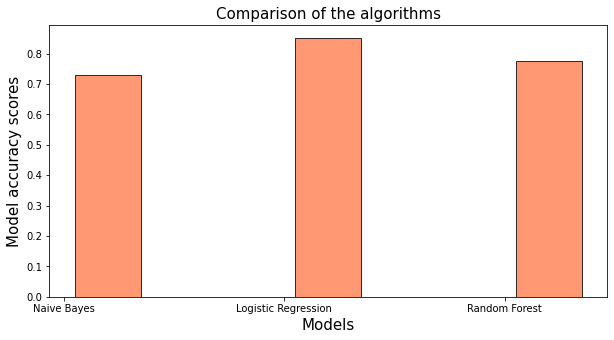

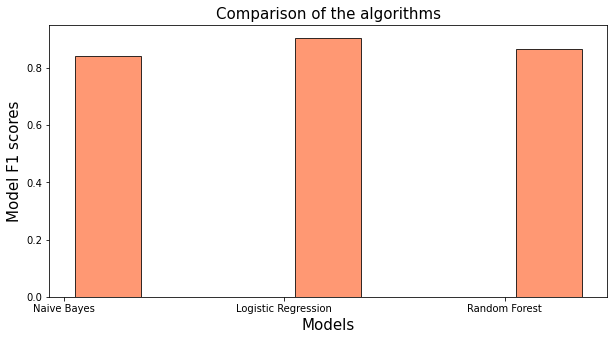

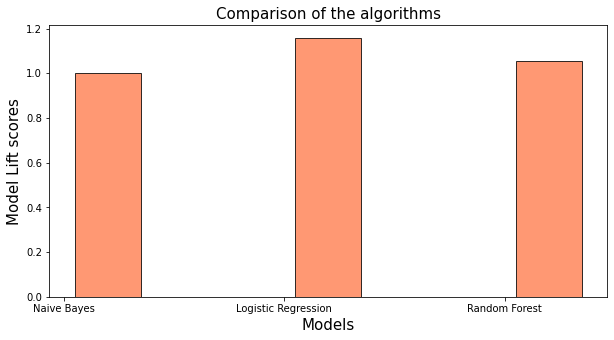

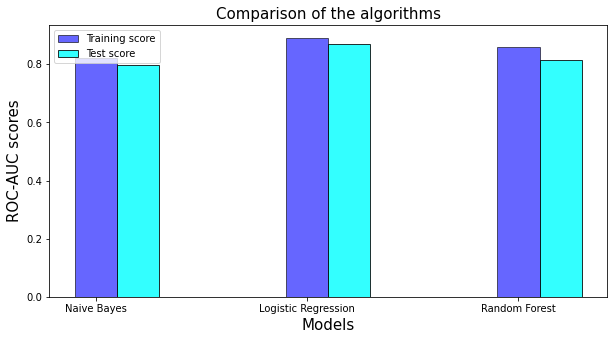

In [27]:
#Plot the accuracy scores:
index=[1, 2, 3]
index_acc=[1.2,2.2,3.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model accuracy scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index_acc, accuracy_score,color='coral',alpha=0.8,label='Accuracy score',edgecolor='k',width=0.3)
plt.xticks([1, 2, 3], myLabels)
plt.show()

#Plot the F1 scores:
index=[1, 2, 3]
index_acc=[1.2,2.2,3.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model F1 scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index_acc,f1_score,color='coral',alpha=0.8,label='F1 score',edgecolor='k',width=0.3)
plt.xticks([1, 2, 3], myLabels)

plt.show()

#Plott the Lift scores:
index=[1, 2, 3]
index_acc=[1.2,2.2,3.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model Lift scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index_acc,lift_score,color='coral',alpha=0.8,label='Lift score',edgecolor='k',width=0.3)
plt.xticks([1, 2, 3], myLabels)

plt.show()

#Plot the ROC-AUC train/test scores:

index=[1, 2, 3]
index_acc=[1.2,2.2,3.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1, 2, 3], myLabels)
plt.legend()
plt.show()

## Hyper Parameter Tuning

### Logistic Regression

In [28]:
# Do a grid search
param_grid = [{
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] 
}]

gs = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_estimator_) 
print(gs.best_score_)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=10, max_iter=1000))])
0.8484224655548018


In [29]:
# Fit the model using the grid search parameters
# Use Pipeline to fit the model
lr_gs = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(max_iter=1000, C=10)),
              ])
lr_gs.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=10, max_iter=1000))])

In [35]:
# Determine the accuracy of the model
y_pred_lr_gs = lr_gs.predict(X_test)
accuracy_lr_gs = lr_gs.score(X_test,y_test)
#f1_lr_gs = f1_score(y_test, y_pred_lr_gs)
#lift_lr_gs = lift_score(y_test, y_pred_lr_gs)

print('Accuracy of Logistic Regression:', accuracy_lr_gs)
#print('F1-Score of Logistic Regression:', f1_lr_gs)
#print('Lift Score of Logistic Regression:', lift_lr_gs)
print(' ')
print(' ')
print(classification_report(y_test, y_pred_lr_gs))

Accuracy of Logistic Regression: 0.867237687366167
 
 
              precision    recall  f1-score   support

         0.0       0.84      0.64      0.72       255
         1.0       0.88      0.95      0.91       679

    accuracy                           0.87       934
   macro avg       0.86      0.80      0.82       934
weighted avg       0.86      0.87      0.86       934



In [33]:
#Calculate the ROC-AUC score
y_scores_lr_gs = lr_gs.predict_proba(X_test)
y_scores_lr_gs = y_scores_lr_gs[:,1]
auroc = roc_auc_score(y_test, y_scores_lr_gs)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.9178780790666783


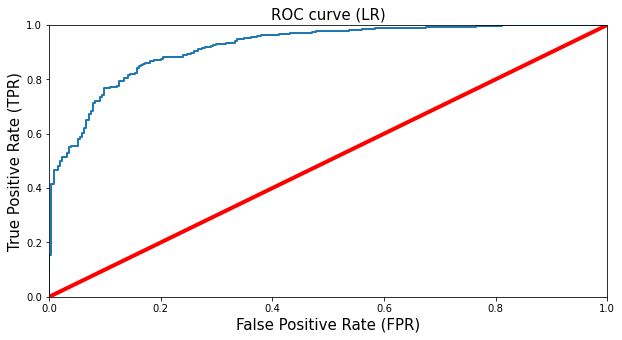

In [34]:
#Create the ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_lr_gs)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (LR)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
# Save plot
plt.savefig(f'../reports/figures/roc_curve.png')
plt.show()